In [1]:
%matplotlib inline
%env OMP_NUM_THREADS=10 
%pylab inline 
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 12]

env: OMP_NUM_THREADS=10
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from typing import List

import g2o
import random
import plotly.graph_objects as go

In [3]:
solver = g2o.BlockSolverX(g2o.LinearSolverEigenX())
solver = g2o.OptimizationAlgorithmLevenberg(solver)

optimizer = g2o.SparseOptimizer()
optimizer.set_verbose(True)
optimizer.set_algorithm(solver)

In [4]:
class VertexEclipse(g2o.VectorXVertex):
    """A Eclipse parameterized by position x,y with short and long radius a,b"""

    def __init__(self) -> None:
        g2o.VectorXVertex.__init__(self)
        # state : [cx,cy,a,b,sita]
        self.set_dimension(5)
        self.set_estimate([0] * 5)

    def oplus_impl(self, update) -> None:
        self.set_estimate(self.estimate() + update)
        
class VertexPoint(g2o.VectorXVertex):
    """A Eclipse points"""

    def __init__(self,n) -> None:
        g2o.VectorXVertex.__init__(self)
        self.set_dimension(n)
        self.set_estimate([0]*n)

    def oplus_impl(self, update) -> None:
        self.set_estimate(self.estimate() + update)
        
class EdgePointOnEclipse(g2o.VariableVectorXEdge):
    def __init__(self) -> None:
        g2o.VariableVectorXEdge.__init__(self)
        self.set_dimension(1)  # dimension of the error function
        self.information()
        self.resize(2)  # number of vertices
        self.set_measurement([0, 0])  # initial measurement

    def compute_error(self):
        eclipse = self.vertex(0).estimate()
        points_angle = self.vertex(1).estimate()
        cx = eclipse[0]
        cy = eclipse[1]
        a = eclipse[2]
        b = eclipse[3]
        sita = eclipse[4]
        
        ex = np.array([a * np.cos(s) for s in points_angle])
        ey = np.array([b * np.sin(s) for s in points_angle])
        
        # rotate long axis by angle sita against x positive
        e=np.vstack([ex,ey])
        rot = np.array([[np.cos(sita),-np.sin(sita)],[np.cos(sita),np.sin(sita)]])
        e = rot.dot(e)
        ex = e[0]
        ey = e[1]
        
        mx = (self.measurement()[:100] - cx)
        my = (self.measurement()[100:] - cy)
        
        error = 0.5 * np.sum((ex-mx)**2 + (ey-my)**2)
        
        
        return [error]

In [5]:
a = np.array([1,2,3])
b = np.array([4,5,6])
c=np.vstack([a,b])

A = np.array([[1,-1],[1,-1]])

In [6]:
A.dot(c)[0]

array([-3, -3, -3])

In [7]:
np.sum((np.array([1,2,3]) - np.array([3,3,3]))**2)

5

In [8]:
num_points: int = 100
max_iterations: int = 100
verbose: bool = True
# TODO: Parse from command line

In [9]:
# generate random data
center: np.ndarray = np.array([4.0, 2.0])
ac: float = 2.0
bc: float = 5.0
points: List[np.array] = []

for _ in range(num_points):
    a = random.gauss(ac, 0.05)
    b = random.gauss(bc,0.05)
    angle = random.uniform(0.0, 2.0 * np.pi)
    points.append(center + np.array([a * np.cos(angle), b * np.sin(angle)]))

In [10]:
# 2. add the points vertex
pointVertex: VertexPoint = VertexPoint(num_points)
pointVertex.set_id(1)

# init angle

## center
center_init = np.array(points).mean(axis=0)

angles = []
for p in points:
    angles.append(np.arctan((p[1]-center_init[1])/(p[0]-center_init[0])))
    
# build the optimization problem given the points
# 1. add the circle vertex
eclipse: VertexEclipse = VertexEclipse()
eclipse.set_id(0)
eclipse.set_estimate([center_init[0],center_init[1], 3.0,3.0,0.0])  # some initial value for the circle
optimizer.add_vertex(eclipse)

pointVertex.set_estimate(angles)
optimizer.add_vertex(pointVertex)
    
edge: EdgePointOnEclipse = EdgePointOnEclipse()
edge.set_information(np.identity(1))
edge.set_vertex(0, eclipse)
edge.set_vertex(1, pointVertex)
edge.set_measurement(np.array(points).T.flatten())
# print(f"error: {edge.compute_error()}")
# print(f"edge slots: {dir(edge)}")
optimizer.add_edge(edge)

True

In [11]:
print(f"Number of vertices: {len(optimizer.vertices())}")
print(f"Number of edges: {len(optimizer.edges())}")

Number of vertices: 2
Number of edges: 1


In [12]:
# perform the optimization
optimizer.initialize_optimization()
optimizer.set_verbose(verbose)
optimizer.optimize(max_iterations)

iteration= 0	 chi2= 862840.782189	 time= 0.0900119	 cumTime= 0.0900119	 edges= 1	 schur= 0	 lambda= 8043.254693	 levenbergIter= 6
iteration= 1	 chi2= 782596.589470	 time= 0.0715538	 cumTime= 0.161566	 edges= 1	 schur= 0	 lambda= 5362.169795	 levenbergIter= 1
iteration= 2	 chi2= 659215.172356	 time= 0.0676304	 cumTime= 0.229196	 edges= 1	 schur= 0	 lambda= 3574.779863	 levenbergIter= 1
iteration= 3	 chi2= 598333.723562	 time= 0.0710935	 cumTime= 0.30029	 edges= 1	 schur= 0	 lambda= 19065.492605	 levenbergIter= 3
iteration= 4	 chi2= 465860.566757	 time= 0.0708695	 cumTime= 0.371159	 edges= 1	 schur= 0	 lambda= 12710.328403	 levenbergIter= 1
iteration= 5	 chi2= 392287.202272	 time= 0.0656087	 cumTime= 0.436768	 edges= 1	 schur= 0	 lambda= 8473.552269	 levenbergIter= 1
iteration= 6	 chi2= 309573.990545	 time= 0.0702935	 cumTime= 0.507061	 edges= 1	 schur= 0	 lambda= 11298.069692	 levenbergIter= 2
iteration= 7	 chi2= 257428.791180	 time= 0.0703493	 cumTime= 0.577411	 edges= 1	 schur= 0	 lam

100

99	 chi2= 105045.515261	 time= 0.0687177	 cumTime= 6.86426	 edges= 1	 schur= 0	 lambda= 70985.753366	 levenbergIter= 2


In [13]:
# print out the result
print("Iterative least squares solution")
print(f"center of the circle: {eclipse.estimate()[0:2]}")
print(f"radius of the circle: {eclipse.estimate()[2:]}")

Iterative least squares solution
center of the circle: [2.81210554 0.90622899]
radius of the circle: [ 4.42541229  1.56853347 -0.47293379]


2.8121055390198224 0.9062289856634759 4.425412290045304 1.5685334692979593


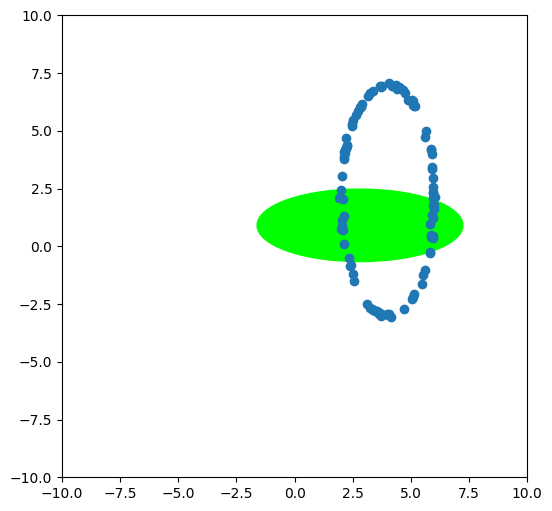

In [14]:
import matplotlib.patches as pat

cx = eclipse.estimate()[0]
cy = eclipse.estimate()[1]

a = abs(eclipse.estimate()[2])
b = abs(eclipse.estimate()[3])
print(cx,cy,a,b)

fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

E = pat.Ellipse(xy=(cx,cy), width=a*2, height=b*2, color="lime")

ax.add_patch(E)
ax.scatter(np.array(points)[:,0],np.array(points)[:,1])
plt.show()

In [19]:
edge.linearize_oplus

(100, 2)

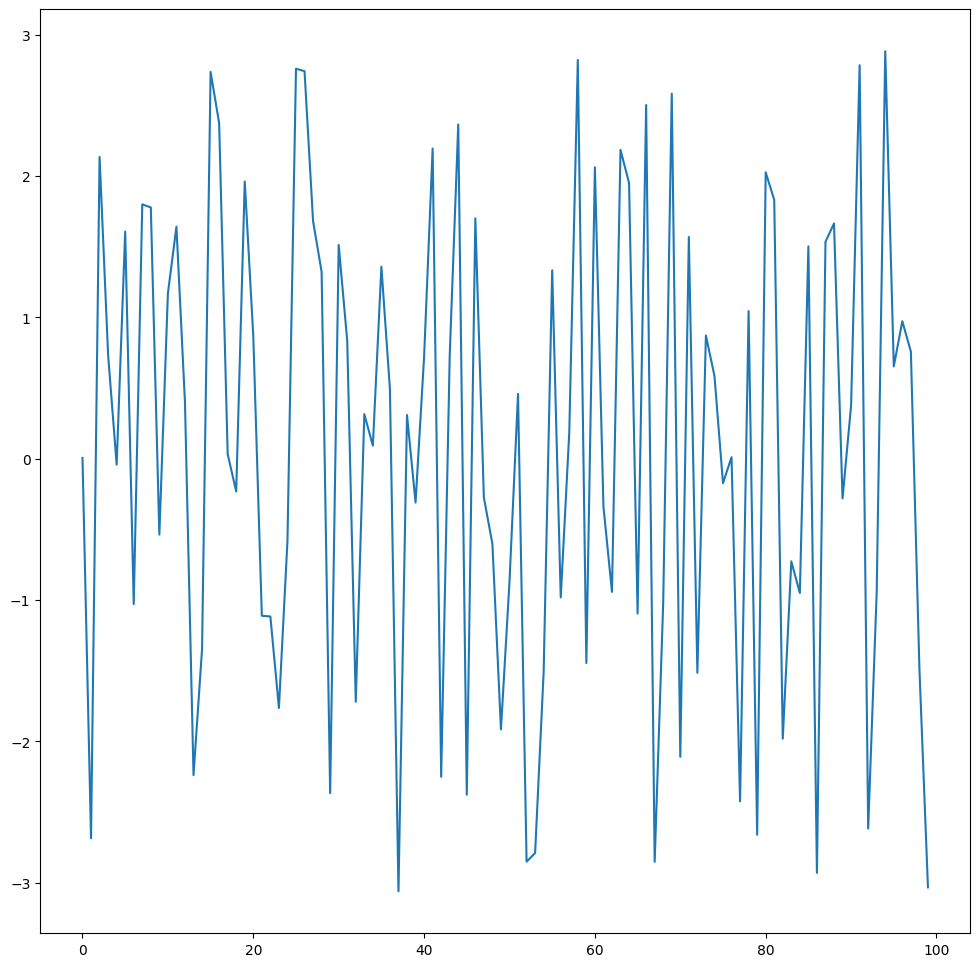

In [20]:
plt.plot(pointVertex.estimate())

In [15]:
g2o.VariableVectorXEdge.linearize_oplus()

TypeError: linearize_oplus(): incompatible function arguments. The following argument types are supported:
    1. (self: g2o.g2opy.DynamicBaseVariableSizedEdge_VectorX, arg0: g2o.g2opy.JacobianWorkspace) -> None
    2. (self: g2o.g2opy.DynamicBaseVariableSizedEdge_VectorX) -> None

Invoked with: 

In [20]:
g2o.JacobianWorkspace.allocate

<instancemethod allocate at 0xffff583907f0>